In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

file_path = "US_Accidents_March23.csv"
chunksize = 500_0000  # Tuned based on your RAM 
#since the dataset contains large amount of data we sampling it chunkwise

# Initialize an empty list to collect filtered or sampled data
data_sample = []

for chunk in pd.read_csv(file_path, chunksize=chunksize, parse_dates=['Start_Time', 'End_Time']):
    # Optional: drop rows with critical missing values
    chunk.dropna(subset=['Start_Lat', 'Start_Lng', 'Start_Time'], inplace=True)
    
    # Take a sample from each chunk for analysis (e.g., 2%)
    sample = chunk.sample(frac=0.02, random_state=42)
    data_sample.append(sample)

# Concatenate all samples
df = pd.concat(data_sample)
print(f"Loaded {df.shape[0]} rows from sampled chunks.")


Loaded 154568 rows from sampled chunks.


In [5]:
# Force datetime conversion
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Drop rows where conversion failed
df.dropna(subset=['Start_Time', 'End_Time'], inplace=True)

# Extract features
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.day_name()
df['Month'] = df['Start_Time'].dt.month_name()
df['Year'] = df['Start_Time'].dt.year


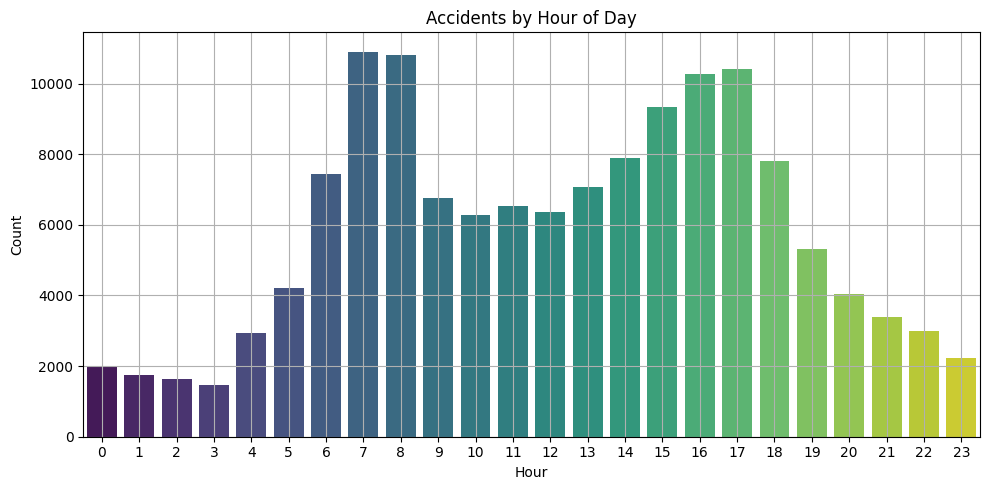

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Hour', palette='viridis')
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


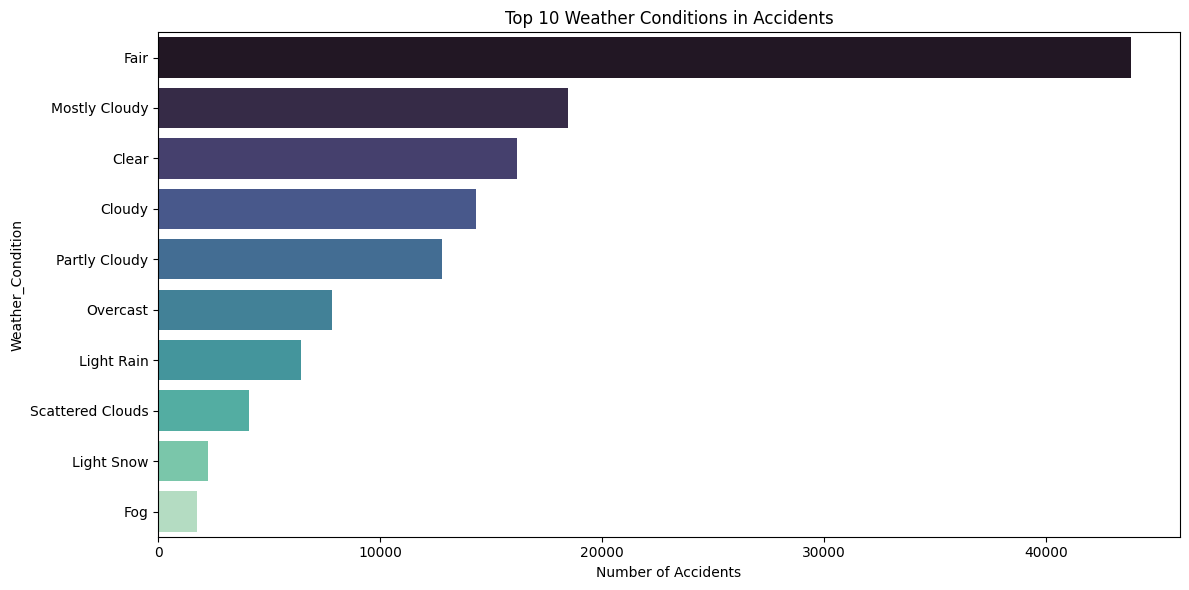

In [7]:
top_weather = df['Weather_Condition'].value_counts().nlargest(10).index
plt.figure(figsize=(12,6))
sns.countplot(data=df[df['Weather_Condition'].isin(top_weather)], 
              y='Weather_Condition', 
              order=top_weather, palette="mako")
plt.title("Top 10 Weather Conditions in Accidents")
plt.xlabel("Number of Accidents")
plt.tight_layout()
plt.show()


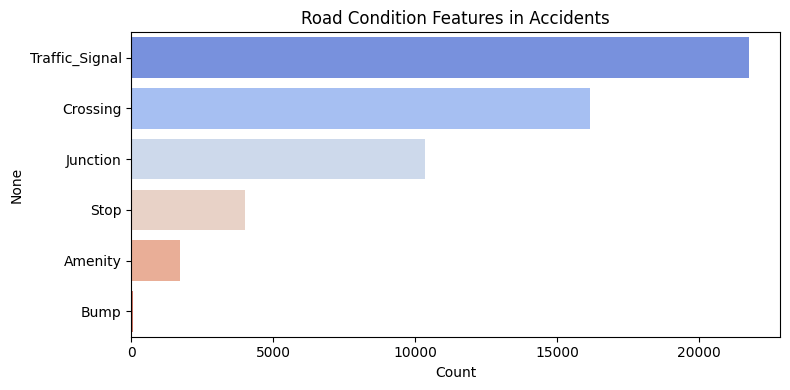

In [8]:
road_flags = ['Amenity', 'Bump', 'Crossing', 'Junction', 'Traffic_Signal', 'Stop']
road_counts = df[road_flags].sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=road_counts.values, y=road_counts.index, palette="coolwarm")
plt.title("Road Condition Features in Accidents")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


In [10]:
import folium
from folium.plugins import HeatMap

# Reduce sample size for performance
sample_map = df[['Start_Lat', 'Start_Lng']].dropna().sample(n=5000, random_state=42)

m = folium.Map(location=[sample_map['Start_Lat'].mean(), sample_map['Start_Lng'].mean()], zoom_start=5)
HeatMap(data=sample_map.values, radius=6).add_to(m)

m.save("accident_hotspots.html")


In [11]:
df.to_csv("accident_sample_cleaned.csv", index=False)
